In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

In [2]:
!pip install kaggle

In [3]:
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets list -s 278k

ref                                                          title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -------------------------------------------  ----  -------------------  -------------  ---------  ---------------  
abdullahorzan/moodify-dataset                                278k Emotion Labeled Spotify Songs           28MB  2023-05-31 01:15:32            933         34  0.8235294        
aestheteaman01/278k-us-wildfires-due-to-lightning-2004-2015  US Wildfires due to Lightning (2004 - 2015)   6MB  2021-08-22 04:40:26            511         27  0.9117647        
viktoriiashkurenko/278k-spotify-songs                        6K Spotify Playlists                         42GB  2023-05-18 17:11:45           1510         41  1.0              


In [5]:
!kaggle datasets download -d abdullahorzan/moodify-dataset

100% 27.7M/27.7M [00:00<00:00, 49.2MB/s]
100% 27.7M/27.7M [00:00<00:00, 39.3MB/s]


In [6]:
!unzip -q moodify-dataset.zip
!ls

278k_labelled_uri.csv  278k_song_labelled.csv  moodify-dataset.zip  sample_data


In [7]:
music_emo = pd.read_csv("./278k_song_labelled.csv", index_col = 0)
music_emo = music_emo.drop(['spec_rate','duration (ms)'], axis=1)
music_emo.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,labels
0,0.611,0.614,-8.815,0.0672,0.0169,0.000794,0.7530,0.520,128.050,2
1,0.638,0.781,-6.848,0.0285,0.0118,0.009530,0.3490,0.250,122.985,1
2,0.560,0.810,-8.029,0.0872,0.0071,0.000008,0.2410,0.247,170.044,1
3,0.525,0.699,-4.571,0.0353,0.0178,0.000088,0.0888,0.199,92.011,0
4,0.367,0.771,-5.863,0.1060,0.3650,0.000001,0.0965,0.163,115.917,1


In [8]:
#number of classes is 3

#checking dimensions
music_emo.shape
#music_emo.describe()

(277938, 10)

<Axes: >

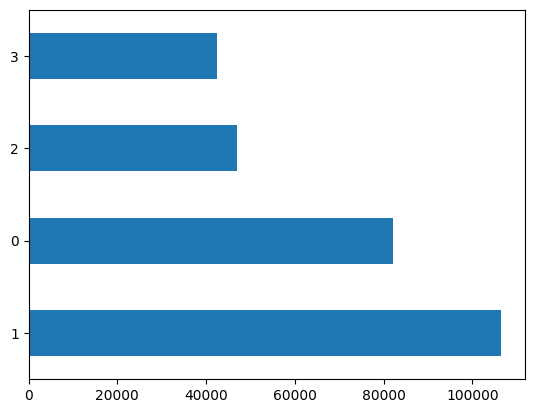

In [9]:
#visualize how many people have improved their mental health
music_emo["labels"].value_counts().plot(kind= 'barh')


In [10]:
print(music_emo.columns)

Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'labels'],
      dtype='object')


In [11]:
elements = music_emo.iloc[:, :9]
elements.head()

mood = music_emo["labels"]
mood.head()

0    2
1    1
2    1
3    0
4    1
Name: labels, dtype: int64

In [12]:
print(elements.shape)

print(mood.shape)


(277938, 9)
(277938,)


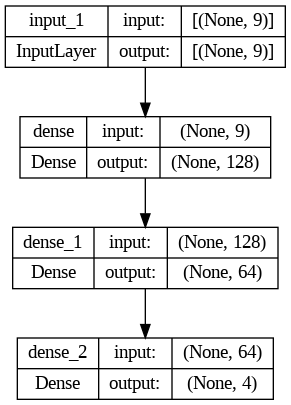

In [13]:
#creating a naive model based on the music effects and the mixture of the frequencies

#first import the necessary modules
import tensorflow as tf # Tensorflow is a neural network and deep neural network library
from tensorflow import keras # Keras is a high-level wrapper that makes working with tensorflow easier
from tensorflow.keras import layers # Layers contains different types of layers such as Dense, Convolutional, Recurrent
from sklearn.model_selection import train_test_split

#split the dataset into training and test
x_train, x_test, y_train, y_test = train_test_split(elements, mood, test_size=0.3)

from sklearn.preprocessing import MinMaxScaler

# define a new scaler:
x_scaler = MinMaxScaler()

# fit the normalization on the training set:
x_scaler.fit(x_train)

# then create new and normalized training/test sets:
x_train_norm = x_scaler.transform(x_train)
x_test_norm = x_scaler.transform(x_test)


#a simple 2-layer model using Keras
def make_model_dense(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Entry block
    # Write dense layers with non-linear activation here.
    if num_classes == 2:
        units = 1
    else:
        units = num_classes # num_class would be different for MNIST.

    outputs = layers.Dense(128, activation="relu")(inputs)
    outputs2 = layers.Dense(64, activation="leaky_relu")(outputs)
    outputs3= layers.Dense(units, activation="softmax")(outputs2)

    return keras.Model(inputs, outputs3)

model = make_model_dense(input_shape= 9, num_classes=4)
keras.utils.plot_model(model, show_shapes=True)

In [14]:
y_train.dtypes

dtype('int64')

Epoch 1/10
2432/2432 [==============================] - 18s 7ms/step - loss: 0.4111 - accuracy: 0.8307 - val_loss: 0.3486 - val_accuracy: 0.8558
Epoch 2/10
2432/2432 [==============================] - 12s 5ms/step - loss: 0.3357 - accuracy: 0.8592 - val_loss: 0.3297 - val_accuracy: 0.8608
Epoch 3/10
2432/2432 [==============================] - 6s 2ms/step - loss: 0.3114 - accuracy: 0.8682 - val_loss: 0.3093 - val_accuracy: 0.8686
Epoch 4/10
2432/2432 [==============================] - 8s 3ms/step - loss: 0.2962 - accuracy: 0.8751 - val_loss: 0.2882 - val_accuracy: 0.8762
Epoch 5/10
2432/2432 [==============================] - 5s 2ms/step - loss: 0.2846 - accuracy: 0.8800 - val_loss: 0.2799 - val_accuracy: 0.8816
Epoch 6/10
2432/2432 [==============================] - 8s 3ms/step - loss: 0.2775 - accuracy: 0.8829 - val_loss: 0.2780 - val_accuracy: 0.8826
Epoch 7/10
2432/2432 [==============================] - 6s 2ms/step - loss: 0.2712 - accuracy: 0.8857 - val_loss: 0.2658 - val_accurac

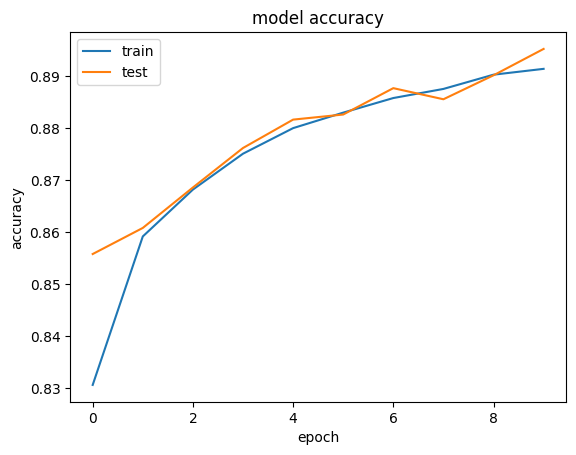

In [15]:
epochs = 10

callbacks = [
    #instruction on where to save the checkpoint, during inf we can load the checkpoint and run the inference
    keras.callbacks.ModelCheckpoint("save_mnist_at_{epoch}.keras"),
    #a technique to avoid overfitting
    #stop the training once the validation accuracy plateaus
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    #waiting for the epoch where the validation accuracy is no longer decreasing
    patience=epochs, # You can change it
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)
]

#using sparse version of categorical crossentropy due to a mismatch in the dimensions of x_train and y_train
model.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    x_train_norm,
    y_train,
    epochs=epochs,
    callbacks=callbacks,
    batch_size = 64,
    validation_split=0.2,
)


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test_norm, y_test, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
1303/1303 [==============================] - 3s 2ms/step - loss: 0.2502 - accuracy: 0.8951
test loss, test acc: [0.2502472996711731, 0.895109236240387]
